# Project: "Identification Of Internet Users»

# Part 2. Data preparation and initial analysis

## 1. Preparing multiple training samples for comparison

Session length - 10 sites, was chosen randomly. We will make the number of sites in the session a parameter, so that in the future we can compare classification models trained on different samples with 5, 7, 10, and 15 sites in the session. We will also create sessions using the idea of a sliding window - overlapping sessions.

**Example of overlapping sessions:** for a session length of 10 and a window width of 7, a file of 30 entries will generate not 3 sessions as before (1-10, 11-20, 21-30), but 5 (1-10, 8-17, 15-24, 22-30, 29-30). At the same time, the penultimate session will have one zero, and the last session will have 8 zeros.

Let's create several selections for different combinations of session length and window width parameters, which are shown in the table:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Thus 18 sparse matrices - 9 combinations of parameters (specified in the table) of session generation for samples of 10 and 150 users will be obtained. At the same time, 2 samples have already been created in Part 1 of the project, they correspond to the combination of parameters: session_length=10, window_size=10.

In [1]:
import os
import re
import itertools
import pickle
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')
from glob import glob
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline

In [2]:
PATH_TO_DATA = 'capstone_user_identification'

In [3]:
pattern = r'\d{4}'

def sparse_matr_gen(X):
    indptr = [0]
    indices = []
    data = []    

    for session in tqdm(X, desc='sessions'):
        for site in session:
            if site == 0: continue
            indices.append(site-1) # For numbering with id = 0 (not id = 1), i.e. deleting a column 0
            data.append(1)
        indptr.append(len(indices))    
    
    return csr_matrix((data, indices, indptr))


def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    '''
    The function generates a session table with variable session_length and window_size parameters.
    
    Parameters:
    - path_to_csv_files – directory path with csv files
    - site_freq_path – path to pickle file with frequency dictionary obtained in 1 Part of the Project
    - session_length – session length
    - window_size – window width
    
    Return:
    - Sparse matrix X (two-dimensional Scipy.sparse.csr_matrix), in which rows correspond to
    sessions from session_length sites, and columns correspond to sites from the previously created frequency dictionary of sites.
    At the intersection of row and column - the number of visits to site_id in session.
    - The y vector (Numpy array) of the "responses" as the ID of the users to whom the session belongs from the X_sparse.
    '''
    sites_per_session = list()
    usr_id = list()
    
    for usr in tqdm(glob(path_to_csv_files + '\\user*.csv'), desc='users'):
        
        sites_queue = pd.read_csv(usr).site.to_list()        
        
        # Calculate the start indexes of the sessions
        indexes = list()
        i = 0
        while i < len(sites_queue):
            indexes.append(i)
            i += window_size
              
        for i in indexes:
            # Creating a session
            sites_per_session.append(sites_queue[i:session_length+i])            
            # Add zeros if necessary.
            if len(sites_per_session[-1]) < session_length:
                while len(sites_per_session[-1]) != session_length:
                    sites_per_session[-1].append(0)
            # Add the user's id
            usr_id.append(int(*re.findall(pattern, usr)))
            
    # Replacing sites with indexes
    with open(site_freq_path, 'rb') as f:
        site_dict = pickle.load(f)
        
    for i, session in enumerate(sites_per_session):
        sites_per_session[i] = list(map(lambda site: site_dict[site][0] if site in site_dict else 0, 
                                        sites_per_session[i]))
    
    return sparse_matr_gen(sites_per_session), usr_id
    

Let's create the 16 previously described training samples and their corresponding response vectors, and then save them to files:

In [4]:
%%time
for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, '{0}users'.format(num_users)),
                                                          os.path.join(PATH_TO_DATA,'site_freq_{0}users.pkl'.format(num_users)),
                                                          session_length, window_size)
            with open(os.path.join(PATH_TO_DATA, 'X_sparse_{0}users_s{1}_w{2}.pkl'.format(num_users, session_length, window_size)), 'wb') as X_pkl:
                pickle.dump(X_sparse, X_pkl, protocol=2)
            with open(os.path.join(PATH_TO_DATA, 'y_{0}users_s{1}_w{2}.pkl'.format(num_users, session_length, window_size)), 'wb') as y_pkl:
                pickle.dump(y, y_pkl, protocol=2)
            

sessions: 100%|████████████████████████████████████████████████████████████| 273957/273957 [00:00<00:00, 756722.53it/s]


Wall time: 33.9 s


## 2. Primary data analysis, hypothesis testing

Upload the `train_data_10users.csv` file prepared in week 1 to the DataFrame. Next we'll work with him.

In [5]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), index_col='session_id')

In [6]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,192,574,133,3,133,133,3,133,203,133,31
1,415,193,674,254,133,31,393,3305,217,55,31
2,55,3,55,55,5,293,415,333,897,55,31
3,473,3306,473,55,55,55,55,937,199,123,31
4,342,55,5,3307,258,211,3308,2086,675,2086,31


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   site1    14061 non-null  int64
 1   site2    14061 non-null  int64
 2   site3    14061 non-null  int64
 3   site4    14061 non-null  int64
 4   site5    14061 non-null  int64
 5   site6    14061 non-null  int64
 6   site7    14061 non-null  int64
 7   site8    14061 non-null  int64
 8   site9    14061 non-null  int64
 9   site10   14061 non-null  int64
 10  user_id  14061 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


**Distribution of a target class:**

In [8]:
train_df['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

**We will calculate the distribution of the number of unique sites in each session out of 10 sites visited in a row:**

In [9]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [10]:
num_unique_sites[:20]

[5, 10, 7, 6, 9, 8, 7, 8, 8, 7, 7, 8, 9, 8, 8, 5, 6, 4, 6, 5]

In [11]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

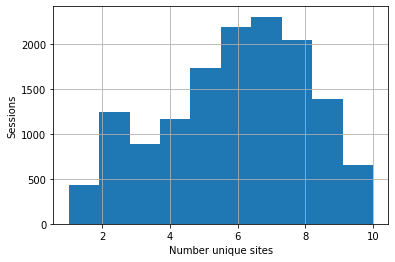

In [12]:
pd.Series(num_unique_sites).hist()
plt.xlabel('Number unique sites')
plt.ylabel('Sessions')
plt.show()

**Using the QQ graph and the Shapiro-Wilk test, we check whether this random variable is distributed normally:**

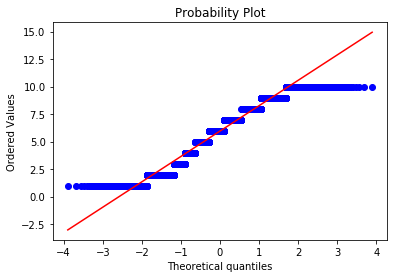

Shapiro-Wilk normality test, W-statistic: 0.954693, p-value: 0.000000


In [13]:
# QQ graph
stats.probplot(num_unique_sites, dist="norm", plot=plt)
plt.show()

# Shapiro-Wilk test
print( "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(num_unique_sites) )

* As you can see from the graph, the distribution is not normal – the maximum values of our distribution are less than the values of the ideal normal distribution, as well as the minimum values are greater than those in the ideal normal distribution.

* The null distribution normality hypothesis is rejected at significance level 0.05.

**Let's test the hypothesis that the user will visit a site that they have previously visited in a session of 10 sites at least once.** 
Using the binomial criterion for the portion, we check that the portion of cases when the user visited a site again (i.e., the number of unique sites in a session < 10) is greater than 95%:

In [14]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')

In [15]:
p_val = stats.binom_test(sum(has_two_similar), len(has_two_similar), 0.95, alternative='greater')
print('p-value:', np.around(p_val, 3))

p-value: 0.022


In other words, the alternative hypothesis that the portion of cases when the user re-visited a site is more than 95% is accepted at the significance level of 0.05.

**95% confidence interval for the portion of cases when the user visited a site again:**

In [16]:
wilson_interval = proportion_confint(sum(has_two_similar), len(has_two_similar), method = 'wilson')

In [17]:
print('[{} {}]'.format(round(wilson_interval[0], 3), round(wilson_interval[1], 3)))

[0.95 0.957]


**Site frequency distribution (how many times a particular site is found in the sample) for sites that have been visited at least 1000 times:**

In [18]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:    
    site_freqs = pd.DataFrame.from_dict(pickle.load(f), orient='index', columns=['id', 'freq'])
    site_freqs_1000 = site_freqs[site_freqs.freq >= 1000]
site_freqs_1000.head()

,id,freq
www.google.com,3,5441
www.facebook.com,5,4141
www.google.fr,2,7813
apis.google.com,6,3758
static.ak.facebook.com,18,1265


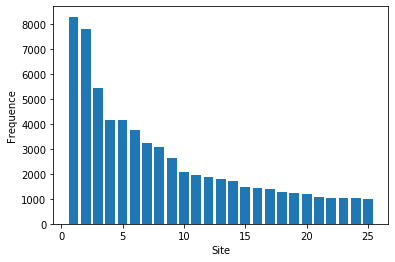

In [19]:
plt.bar(site_freqs_1000.id, site_freqs_1000.freq)
plt.xlabel('Site')
plt.ylabel('Frequence')
plt.show()

**95% confidence interval for the median frequency of site appearance in the sample (in all, not just for sites that have been visited at least 1000 times) based on bootstrap:**

In [20]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [21]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [22]:
median_scores = list(map(np.average, get_bootstrap_samples(site_freqs.freq[::-1], len(site_freqs.freq))))
print("95% confidence interval for the median frequency:",  np.around(stat_intervals(median_scores, 0.05), 3))

95% confidence interval for the median frequency: [22.361 36.115]


## Result:
* For further analysis, samples with different session lengths and window widths were constructed.
* Initial data analysis was performed and hypotheses were tested.

In Part 3 (part3_visual_analysis_and_fe.ipynb) of the Project, visual data analysis and feature construction are implemented.